# Fig 4: Matrix Figure to Check Accuracy of NN

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from os import path

from loss_cal.costs import (
    RevGaussCost,
    expected_posterior_costs_given_posterior_samples,
)
from loss_cal.tasks.lotka_volterra import LotkaVolterra
from loss_cal.npe import load_npes
from loss_cal.bam import load_predictors

task_name = "lotka_volterra"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plot_config_file = "./loss_cal/utils/.matplotlibrc"
color_npe = '#377eb8'
color_nn = '#ff7f00'
color_post = '#4daf4a'
save_dir = f"./paper/fig4/"

action_type="continuous"

seed = 0
num_action_samples = "inloop" #"100actions" 

#### Get reference samples

In [3]:
lv = LotkaVolterra(action_type=action_type)
x_reference = torch.vstack([lv.get_observation(i) for i in range(1, 11)])
post_reference = torch.stack([lv.get_reference_samples(i) for i in range(1, 11)])
param_reference = torch.vstack([lv.get_true_parameters(i) for i in range(1, 11)])

In [12]:
factors = [3.]*4
exponentials = [2.]*4

cost_fns = [
    RevGaussCost(
        parameter_range=[lv.param_low[p], lv.param_high[p]] ,
        action_range=[lv.action_low, lv.action_high],
        factor=factors[p],
        exponential=exponentials[p],
    )
    for p in range(lv.dim_parameters)
]

actions = torch.arange(lv.action_low, lv.action_high+0.01, 1.0)

In [13]:
num_simulations = 10_000

#### Expected costs

In [14]:
posterior_expected_costs = torch.empty((lv.dim_parameters, lv.num_observations, actions.numel()))

for obs in range(10):  # iterate over reference samples
    for param in range(lv.dim_parameters):
        posterior_expected_costs[param, obs] = lv.expected_posterior_costs(
            x=obs + 1, a=actions, param=param, cost_fn=cost_fns[param]
        ).squeeze()

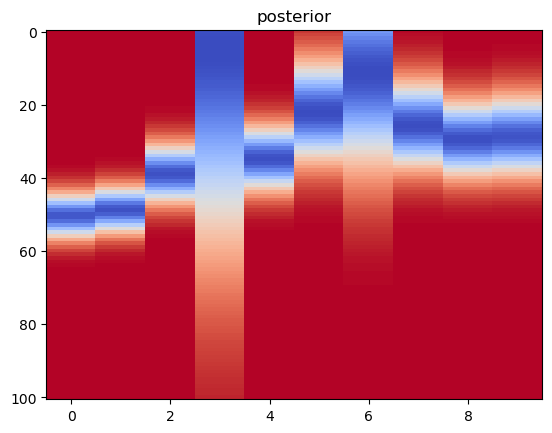

In [15]:
plt.title("posterior")
plt.imshow(posterior_expected_costs[3, :, :].T, aspect="auto", cmap="coolwarm")

#### NPE Predictions

In [16]:
flow = "nsf"
npe_posteriors, num_simulations_npe = load_npes(f"./results/{task_name}/npe/{seed}", flow=flow)
num_npe_samples = 1000

Loading npe trained on ... simulations:
-  500
-  1000
-  5000
-  10000
-  50000
-  100000


In [17]:
npe_posterior = npe_posteriors[num_simulations_npe.index(num_simulations)]
npe_expected_costs = torch.empty((lv.dim_parameters, lv.num_observations, actions.numel()))

for obs in range(10):  # iterate over reference samples
    npe_samples = npe_posterior.sample((num_npe_samples,), x=x_reference[obs], show_progress_bars=False)
    for param in range(lv.dim_parameters):  # iterate over parameters
        npe_expected_costs[param, obs] = expected_posterior_costs_given_posterior_samples(
            post_samples=lv.param_aggregation(npe_samples),
            actions=lv.actions,
            a=actions,
            param=param,
            cost_fn=cost_fns[param],
        ).squeeze()

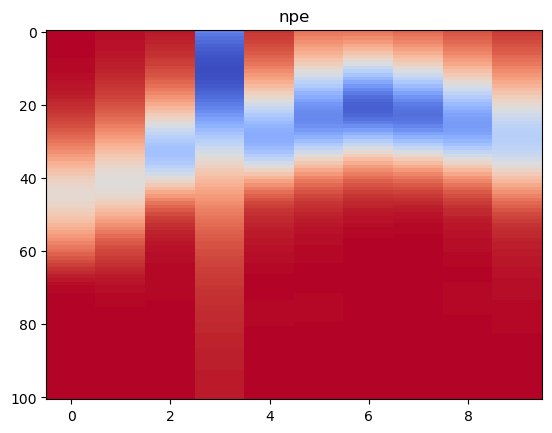

In [18]:
plt.title("npe")
plt.imshow(npe_expected_costs[3].T, aspect="auto", cmap="coolwarm", vmin=0, vmax=1)

#### NN Predictions

In [ ]:
experiment = "vary_sim"
models = []  # list of lists
to_str = lambda n: str(int(n)) if n.is_integer() else str(n).replace(".", "_")
for param in range(lv.dim_parameters):
    dir = f"./results/{task_name}/{action_type}/nn/fc/{experiment}/{seed}/{num_action_samples}/2023-12*param_{param}_factor_{to_str(factors[param])}_exp_{to_str(exponentials[param])}"
    models_param, num_simulations_nn = load_predictors(task_name, action_type=action_type, dir=dir)
    models.append(models_param)

In [20]:
nn_expected_costs = torch.empty((lv.dim_parameters, lv.num_observations, actions.numel()))


with torch.no_grad():
    for param in range(lv.dim_parameters):
        model = models[param][num_simulations_nn.index(num_simulations)]

        for obs in range(10):  # iterate over reference samples
            nn_expected_costs[param, obs] = model(x_reference[obs].repeat(actions.numel(), 1), actions).squeeze()

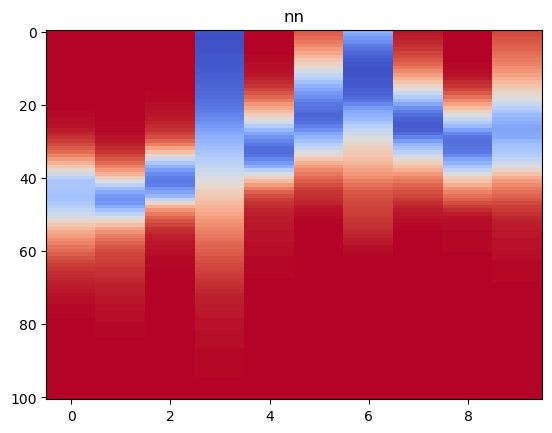

In [21]:
plt.title("nn")
plt.imshow(nn_expected_costs[3].T, aspect="auto", cmap="coolwarm", vmin=0, vmax=1)

## Matrix Figure

### All thresholds

/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_17603/2083799593.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = mpl.cm.get_cmap('Oranges_r', 128)
/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_17603/2083799593.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = mpl.cm.get_cmap('Blues', 128)


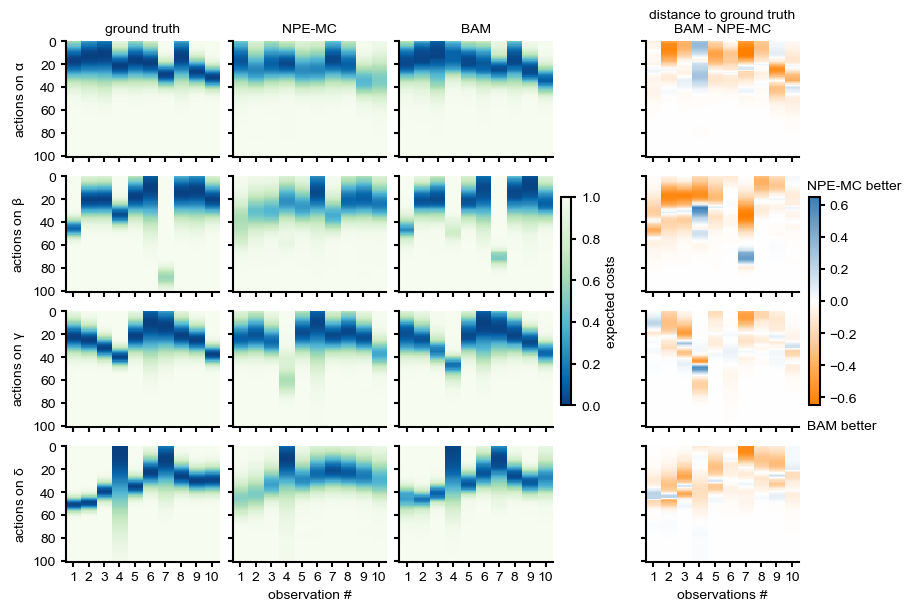

tensor(-0.6835) tensor(0.6203)


In [29]:
labels = ["alpha", "beta", "gamma", "delta"]
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)

newcolors = torch.vstack((torch.Tensor(top(torch.linspace(0, 1, 128).numpy())),
                       torch.Tensor(bottom(torch.linspace(0, 1, 128).numpy()))))
cmap_orablu_intense = ListedColormap(newcolors.numpy(), name='OrangeBlue')
cmap_orablu = mpl.colors.LinearSegmentedColormap.from_list("", [color_nn, "white",color_npe])


with mpl.rc_context(fname=plot_config_file):
    with torch.no_grad():
        rows = 4
        cols = 4
        n_actions = actions.shape[0]
        fig, axes = plt.subplots(
            rows, cols, figsize=(9, 6), gridspec_kw={"height_ratios": rows * [n_actions]}, constrained_layout=True, sharex=True, sharey=True
        )
        titles = ["ground truth", "NPE-MC", "BAM", "distance to ground truth\nBAM - NPE-MC"]
        y_ticks_subsample = 20

        npe_diff = posterior_expected_costs - npe_expected_costs
        clf_diff = posterior_expected_costs - nn_expected_costs
        diff = torch.abs(clf_diff) - torch.abs(npe_diff)
        diff_cmap_range = torch.round((torch.abs(diff.min()) + torch.abs(diff.max())) / 2, decimals=2)
        # diff:
        # positive values = different of nn is larger (less accurate)
        # negative values = npe diff is larger (nn more accurate)

        axes[-1, 1].set_xlabel("observation #")
        axes[-1, -1].set_xlabel("observations #")
        axes[-1, -1].set_yticks(torch.arange(actions.max()+0.01).numpy()[::y_ticks_subsample])
        axes[-1, -1].set_xticks(torch.arange(10).numpy())
        axes[-1, -1].set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        
        for col, ratio in enumerate([posterior_expected_costs, npe_expected_costs, nn_expected_costs, None]):
            for param in range(rows):
                if col == cols - 1:
                    im_diff = axes[param, col].imshow(
                        diff[param : param + 1].T,
                        aspect="auto",
                        cmap=cmap_orablu, #"PRGn_r",  # cmap_diff,
                        vmin=-diff_cmap_range,
                        vmax=diff_cmap_range,
                    )
                else:
                    im = axes[param, col].imshow(
                        ratio[param].T,
                        aspect="auto",
                        cmap="GnBu_r",  # "viridis",
                        vmin=0,
                        vmax=1,
                    )
                if col == 0:
                    axes[param, col].set_ylabel(rf"actions on $\{labels[param]}$")
                if param == 0:
                    axes[param, col].set_title(titles[col])

        fig.colorbar(im, ax=axes[:, col - 1], shrink=0.4, location="right", label="expected costs\n")

        fig.colorbar(im_diff, ax=axes[:, col], cmap="PRGn_r", shrink=0.4, location="right")
        plt.gcf().axes[-1].text(-0.2,0.7,"NPE-MC better") #set(title="NPE-MC closer", xlabel="BAM closer")
        plt.gcf().axes[-1].text(-0.2,-0.8,"BAM better")
        plt.savefig('./paper/fig4/fig4.svg')
        plt.show()

        print(diff.T.min(), diff.T.max())

/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_17603/2856993392.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = mpl.cm.get_cmap('Oranges_r', 128)
/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_17603/2856993392.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = mpl.cm.get_cmap('Blues', 128)


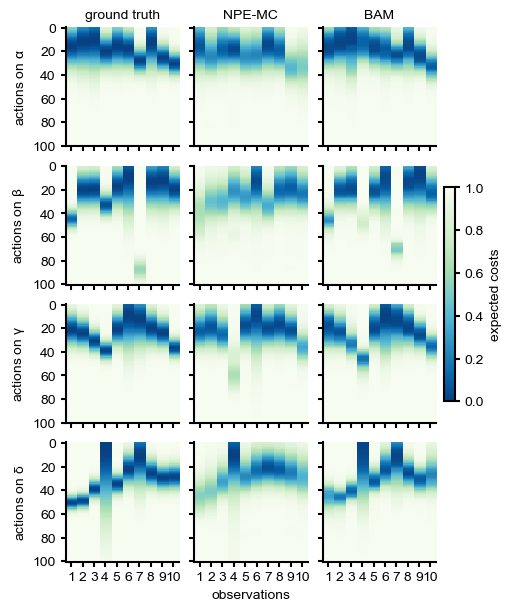

tensor(-0.6835) tensor(0.6203)


In [30]:
labels = ["alpha", "beta", "gamma", "delta"]
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)

newcolors = torch.vstack((torch.Tensor(top(torch.linspace(0, 1, 128).numpy())),
                       torch.Tensor(bottom(torch.linspace(0, 1, 128).numpy()))))
cmap_orablu_intense = ListedColormap(newcolors.numpy(), name='OrangeBlue')
cmap_orablu = mpl.colors.LinearSegmentedColormap.from_list("", [color_nn, "white",color_npe])


with mpl.rc_context(fname=plot_config_file):
    with torch.no_grad():
        rows = 4
        cols = 3
        n_actions = actions.shape[0]
        fig, axes = plt.subplots(
            rows, cols, figsize=(5, 6), gridspec_kw={"height_ratios": rows * [n_actions]}, constrained_layout=True, sharex=True, sharey=True
        )
        titles = ["ground truth", "NPE-MC", "BAM", "distance to ground truth\nBAM - NPE-MC"]
        y_ticks_subsample = 20

        npe_diff = posterior_expected_costs - npe_expected_costs
        clf_diff = posterior_expected_costs - nn_expected_costs
        diff = torch.abs(clf_diff) - torch.abs(npe_diff)
        diff_cmap_range = torch.round((torch.abs(diff.min()) + torch.abs(diff.max())) / 2, decimals=2)
        # diff:
        # positive values = different of nn is larger (less accurate)
        # negative values = npe diff is larger (nn more accurate)

        axes[-1, 1].set_xlabel("observations")
        axes[-1, -1].set_yticks(torch.arange(actions.max()+0.01).numpy()[::y_ticks_subsample])
        axes[-1, -1].set_xticks(torch.arange(10).numpy())
        axes[-1, -1].set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        
        for col, ratio in enumerate([posterior_expected_costs, npe_expected_costs, nn_expected_costs]): #, None]):
            for param in range(rows):
                if col == 4: #cols - 1:
                    im_diff = axes[param, col].imshow(
                        diff[param : param + 1].T,
                        aspect="auto",
                        cmap=cmap_orablu, #"PRGn_r",  # cmap_diff,
                        vmin=-diff_cmap_range,
                        vmax=diff_cmap_range,
                    )
                else:
                    im = axes[param, col].imshow(
                        ratio[param].T,
                        aspect="auto",
                        cmap="GnBu_r",  # "viridis",
                        vmin=0,
                        vmax=1,
                    )
                if col == 0:
                    axes[param, col].set_ylabel(rf"actions on $\{labels[param]}$")
                if param == 0:
                    axes[param, col].set_title(titles[col])

        #fig.colorbar(im, ax=axes[:, col - 1], shrink=0.4, location="right", label="expected costs")
        fig.colorbar(im, ax=axes[:, col], shrink=0.4, location="right", label="expected costs")

        # fig.colorbar(im_diff, ax=axes[:, col], cmap="PRGn_r", shrink=0.4, location="right")
        # plt.gcf().axes[-1].text(-0.2,0.95,"NPE-MC closer") #set(title="NPE-MC closer", xlabel="BAM closer")
        # plt.gcf().axes[-1].text(-0.2,-1.05,"BAM closer")
        plt.savefig('./paper/fig4/panel_a.svg')
        plt.show()

        print(diff.T.min(), diff.T.max())

/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_17603/3252604061.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = mpl.cm.get_cmap('Oranges_r', 128)
/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_17603/3252604061.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = mpl.cm.get_cmap('Blues', 128)


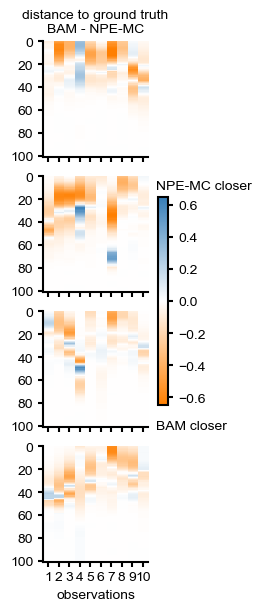

tensor(-0.6835) tensor(0.6203)


In [32]:
labels = ["alpha", "beta", "gamma", "delta"]
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)

newcolors = torch.vstack((torch.Tensor(top(torch.linspace(0, 1, 128).numpy())),
                       torch.Tensor(bottom(torch.linspace(0, 1, 128).numpy()))))
cmap_orablu_intense = ListedColormap(newcolors.numpy(), name='OrangeBlue')
cmap_orablu = mpl.colors.LinearSegmentedColormap.from_list("", [color_nn, "white",color_npe])


with mpl.rc_context(fname=plot_config_file):
    with torch.no_grad():
        rows = 4
        cols = 1
        n_actions = actions.shape[0]
        fig, axes = plt.subplots(
            rows, cols, figsize=(2.5, 6), gridspec_kw={"height_ratios": rows * [n_actions]}, constrained_layout=True, sharex=True, sharey=True
        )
        titles = ["ground truth", "NPE-MC", "BAM", "distance to ground truth\nBAM - NPE-MC"]
        y_ticks_subsample = 20

        npe_diff = posterior_expected_costs - npe_expected_costs
        clf_diff = posterior_expected_costs - nn_expected_costs
        diff = torch.abs(clf_diff) - torch.abs(npe_diff)
        diff_cmap_range = torch.round((torch.abs(diff.min()) + torch.abs(diff.max())) / 2, decimals=2)
        # diff:
        # positive values = different of nn is larger (less accurate)
        # negative values = npe diff is larger (nn more accurate)

        axes[-1].set_xlabel("observations")
        axes[-1].set_yticks(torch.arange(actions.max()+0.01).numpy()[::y_ticks_subsample])
        # axes[-1, -1].set_yticklabels(
        #     list(torch.round(actions, decimals=0).numpy()[::y_ticks_subsample])
        # )
        axes[-1].set_xticks(torch.arange(10).numpy())
        axes[-1].set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        
        for param in range(rows):
            im_diff = axes[param].imshow(
                    diff[param : param + 1].T,
                    aspect="auto",
                    cmap=cmap_orablu, #"PRGn_r",  # cmap_diff,
                    vmin=-diff_cmap_range,
                    vmax=diff_cmap_range,
                )
            if param == 0:
                axes[param].set_title(titles[-1])

        fig.colorbar(im_diff, ax=axes, cmap="PRGn_r", shrink=0.4, location="right")
        plt.gcf().axes[-1].text(-0.2,0.7,"NPE-MC closer") #set(title="NPE-MC closer", xlabel="BAM closer")
        plt.gcf().axes[-1].text(-0.2,-0.8,"BAM closer")

        plt.savefig('./paper/fig4/panel_b.svg')
        plt.show()

        print(diff.T.min(), diff.T.max())

## Combine all panels into one SVG

In [33]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("21.59cm", "15.0cm", #20.3 = width of document (check!)
           
    Panel(
          SVG("./paper/fig4/fig4.svg").scale(svg_scale),
          Text("a", 20., 10.0, **kwargs_text),
          Text("b", 550., 10.0, **kwargs_text),
    ).move(0, 10),
)

f.save("./paper/fig4/fig4.svg")
f

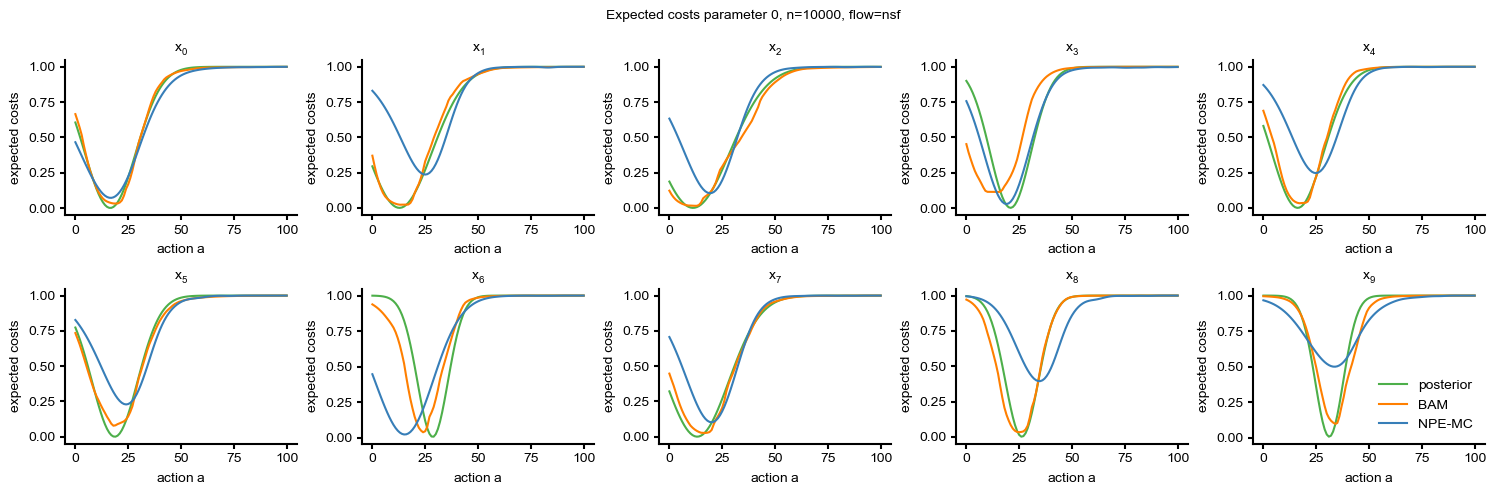

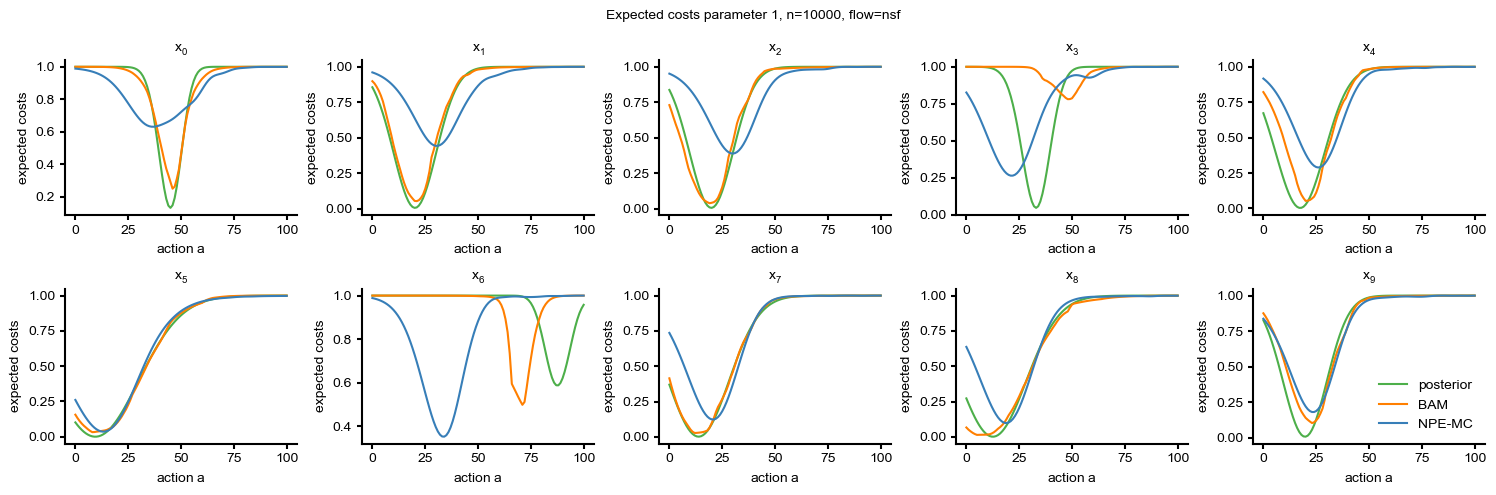

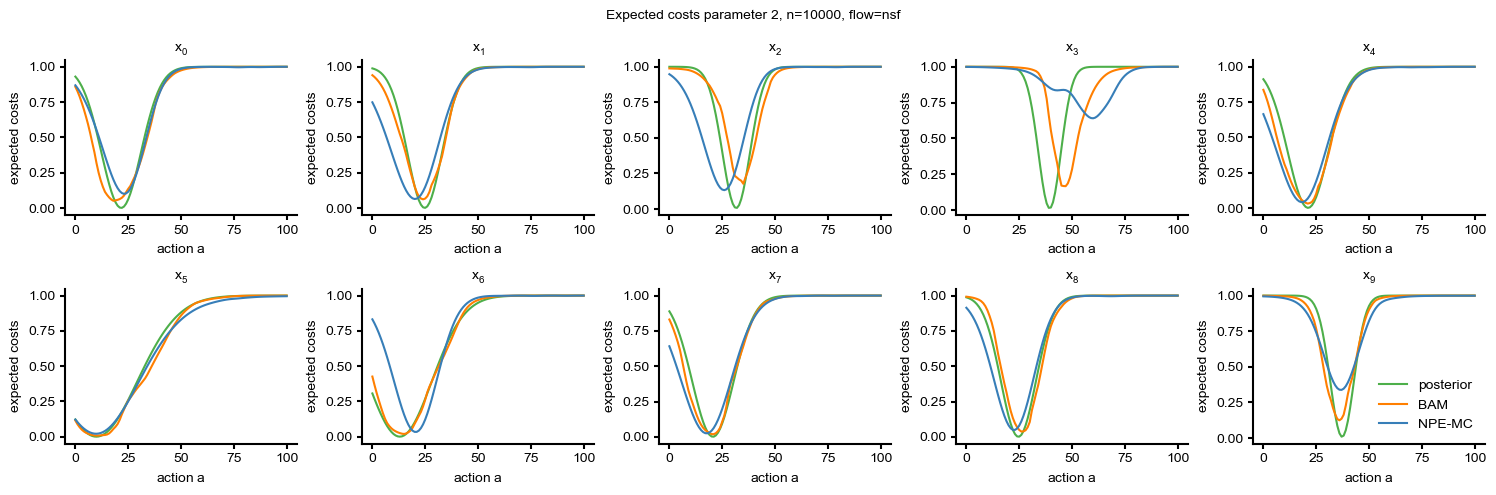

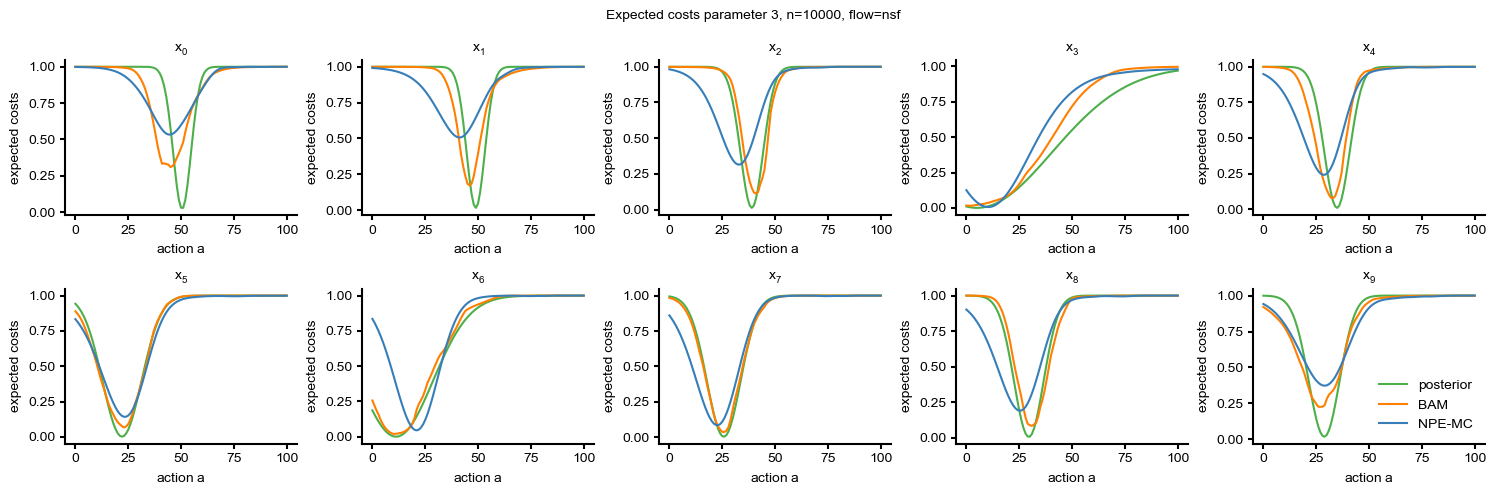

In [34]:
for plot_param in range(lv.dim_parameters):
    with mpl.rc_context(fname=plot_config_file):
        with torch.no_grad():
            rows = 2
            cols = 5
            plt.figure(figsize=(15, 5))
            for i, x in enumerate(x_reference):
                plt.subplot(rows, cols, i + 1 % cols)
                plt.plot(actions, posterior_expected_costs[plot_param, i, :], c=color_post, label="posterior")
                plt.plot(actions, nn_expected_costs[plot_param, i, :], c=color_nn, label="BAM")
                plt.plot(actions, npe_expected_costs[plot_param, i, :], c=color_npe, label="NPE-MC")
                plt.xlabel(r"action $a$")
                plt.ylabel("expected costs")
                plt.title(rf"$x_{i}$")
        plt.suptitle(f"Expected costs parameter {plot_param}, n={num_simulations}, flow={flow}")
        plt.tight_layout()
        plt.legend()

        plt.savefig(path.join(save_dir, f"seed{seed}_fig_expected_costs_nsim{num_simulations}_param{plot_param}.pdf"))
        plt.savefig(path.join(save_dir, f"seed{seed}_fig_expected_costs_nsim{num_simulations}_param{plot_param}.png"))
        # plt.savefig(
        #     path.join(save_dir, f"fig_expected_costs_param{param}_factor{factor}_exp{exponential}_nsim{num_simulations}_{flow}.pdf")
        # )
        plt.show()